:

<h1><center>ANALYZING THE IMPACT OF BEHAVIORAL AND ENVIRONMENTAL DETERMINANTS ON HEALTH STATUS IN THE UNITED STATES</center></h1>
<center>Ivan Camps</center>
<center>October 18, 2020</center>




In [24]:
# Read in all the libraries and data
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
from sklearn import tree
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
import os

filePath = "/Users/ivanca/OneDrive/Documents/PENN/FALL 2020/STAT 477/Homework/Project"
os.chdir(filePath) 

county_data = pd.read_csv("project_477.csv", index_col='Row.Label')
county_data.drop(['County.FIPS.Code', 'Election.Results.2016', 'Uninsured', 'Primary.Care.Physicians.Per.1000', 
                  'Mental.health.providers.Per.1000', 'High.School.Graduation', 'Adult.Obesity', 
                  'Food.Insecurity.Quintile', 'Severe.Housing.Problems', 'Unemployment','Percent.Rural', 
                  'Percent.Females', 'Life.Expectancy', 'Population'], axis=1, inplace=True)

In [25]:
county_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2715 entries, AL_Autauga County to WY_Weston County
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Five-digit.FIPS.Code        2715 non-null   int64  
 1   State.FIPS.Code             2715 non-null   int64  
 2   State.Abbreviation          2715 non-null   object 
 3   CountyName                  2715 non-null   object 
 4   Poor.Health                 2715 non-null   float64
 5   Proportion.of.Smokers       2715 non-null   float64
 6   Insufficient.Sleep          2715 non-null   float64
 7   Physical.Inactivity         2715 non-null   float64
 8   Excessive.Drinking          2715 non-null   float64
 9   Median.Household.Income     2715 non-null   int64  
 10  Income.Inequality.Quartile  2715 non-null   object 
 11  Over.65                     2715 non-null   float64
dtypes: float64(6), int64(3), object(3)
memory usage: 275.7+ KB


<h2><center>Outline</center></h2>

* <b>1. Introduction</b> 
* <b>2. Exploring the Data</b>
* <b>3. Fitting the Decision Tree</b>
* <b>4. Conclusions</b> 


<h2><center>1. INTRODUCTION</center></h2>

<h3><center>Understanding the Data</center></h3>

* <b>Dataset Description:</b> the dataset describes health, economic and demographic characteristics of counties in the US.
    * File: "project_477.csv"
    * Source: https://www.countyhealthrankings.org/

* <b>Y-Variable Description:</b> the outcome variable will be the health index. The variable "Poor Health", represents the proportion of the county that has a poor health status. 



<h3><center>Understanding the Data</center></h3>

* <b>Predictor Variables:</b> 
    * Proportion of Smokers: the percentage of smokers in the county
    * Insufficient sleep: the percentage of the county population who do not get enough sleep
    * Physical Inactivity: the percentage of the county who is not physically active
    * Excessive Drinking:  the percentage of heavy drinkers in the county
    * Median Household Income: in USD, in each county
    * Income Inequality Quartile: county-wide bucketed metric, with 1 being the least unequal and 4 having the largest disparity
    * Over 65: percentage of the population of the county over 65 years old

<h3><center>Objectives</center></h3>

* The main objective will be to identify the main precursors of poor health, for which we will fit a decision tree regression model.
* The analysis will focus on studying the impact of behavioral and environmental social determinants on health status.
* Some questions we will seek answer for in the process are: 
 * How do bad habits such as inactivity, insufficient sleep, smoking, and drinking affect health?  
 * What is the relationship between median household income and income inequality in a county and overall health status? 
 * Is there a relationship between the behavioral and the environmental social determinants of health?
 * What is the impact of age on health status?
 * What combination of variables leads to the best and worst health status? Are bad habits or socioeconomic status more relevant in predicting poor health?

<h2><center>2. EXPLORING THE DATA</center></h2>
<h3><center>Outcome Variable Overview</center></h3>

* The following code fragments generate statistics and plots to summarize our outcome variable, "Poor Health". 
* We can see that the overall percentage of individuals with poor health is low, with a mean of 17%. 

In [26]:
np.round(county_data['Poor.Health'].describe(), 2)

count    2715.00
mean        0.17
std         0.05
min         0.08
25%         0.14
50%         0.17
75%         0.20
max         0.41
Name: Poor.Health, dtype: float64

<h3><center>Outcome Variable Overview</center></h3>

* The distribution of the variable is significantly right-skewed indicating the existence of a good number of outlier counties with higher percentages of poor health. 


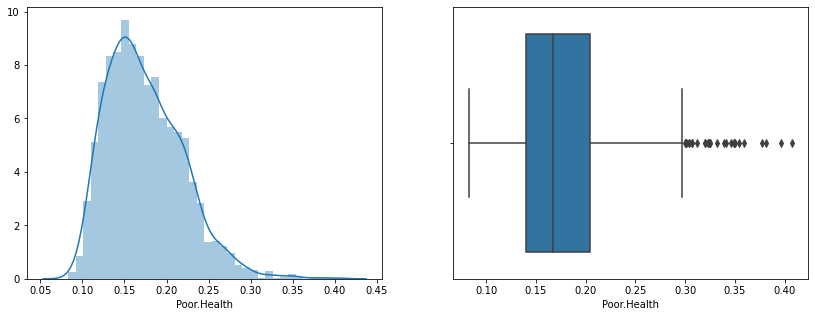

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(14,5))
sns.distplot(county_data['Poor.Health'], ax=axs[0]);
sns.boxplot(county_data['Poor.Health'], ax=axs[1]);

<h3><center>Outcome Variable Overview</center></h3>

* The following chart shows the health index by state. There is, on average, a higher percentage of poor health in southern states.


In [28]:
plotly.offline.init_notebook_mode(connected=True)
s =county_data.groupby(['State.Abbreviation'])['Poor.Health'].mean().reset_index()
us = px.choropleth(s, locations = 'State.Abbreviation', color='Poor.Health', locationmode='USA-states', scope="usa")
us.update_layout(autosize=False, width=700, height=300, margin={"r":0,"t":0,"l":0,"b":0})

<h3><center>Predictor Variables Overview</center></h3>

* The following table shows the basic summary statistics of the continuous $X$-variables. 
* We can see that insufficient sleep is the most widespread bad habit across counties, with a mean of 33%, followed by physical inactivity, with a 26% mean. 

In [29]:
np.round(county_data.iloc[:,5:12].describe(), 2)

,Proportion.of.Smokers,Insufficient.Sleep,Physical.Inactivity,Excessive.Drinking,Median.Household.Income,Over.65
count,2715.00,2715.00,2715.00,2715.00,2715.00,2715.00
mean,0.18,0.33,0.26,0.17,51606.56,0.19
std,0.03,0.04,0.05,0.03,13650.71,0.04
min,0.07,0.23,0.08,0.09,25569.00,0.05
25%,0.15,0.30,0.22,0.15,42680.00,0.16
50%,0.17,0.33,0.26,0.17,49350.00,0.18
75%,0.20,0.36,0.29,0.20,57274.50,0.21
max,0.33,0.47,0.45,0.29,136191.00,0.57


<h3><center>Predictor Variables Overview</center></h3>

* The following figures show the distribution of the $X$-variables. 
* We will look at income inequality in future slides.

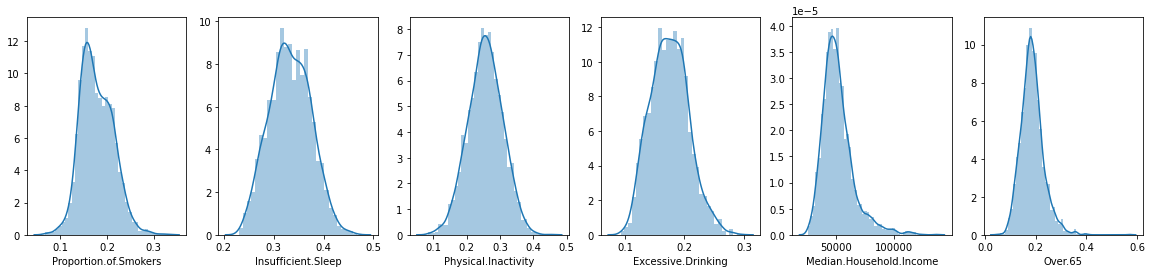

In [30]:
fig, axs = plt.subplots(ncols=6, figsize=(20,4))
sns.distplot(county_data['Proportion.of.Smokers'], ax=axs[0]);
sns.distplot(county_data['Insufficient.Sleep'], ax=axs[1]);
sns.distplot(county_data['Physical.Inactivity'], ax=axs[2]);
sns.distplot(county_data['Excessive.Drinking'], ax=axs[3]);
sns.distplot(county_data['Median.Household.Income'], ax=axs[4]);
sns.distplot(county_data['Over.65'], ax=axs[5]);

<h3><center>Predictor Variables Overview</center></h3>

* The heatmap shows significant correlation between most bad habits and poor health, as well as between income and poor health, as expected. 
* Surprisingly, excessive drinking is negatively correlated with poor health and smoking, and age is not correlated with poor health.

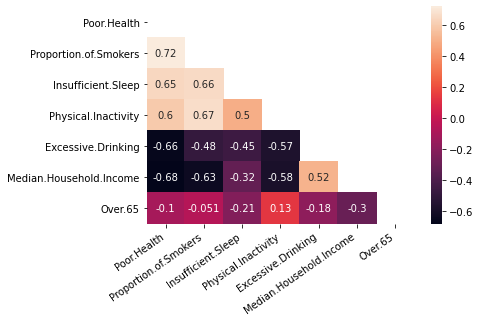

In [31]:
corr = county_data.iloc[:,4:12].corr()
sns.heatmap(corr, annot=True, mask=np.triu(np.ones_like(corr, dtype=bool)));
plt.xticks(rotation=35, horizontalalignment='right');

<h3><center>Behavioral Social Determinants vs. Health</center></h3>

* The following regression plots expand on the correlations we found previously. 

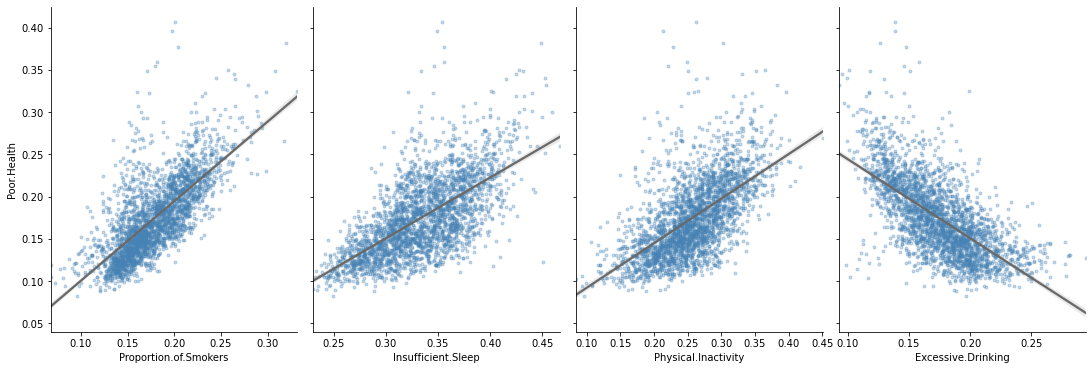

In [32]:
c = ['Proportion.of.Smokers', 'Insufficient.Sleep', 'Physical.Inactivity', 'Excessive.Drinking']
sns.pairplot(data=county_data, y_vars=['Poor.Health'], x_vars=c, kind='reg',
              plot_kws={'line_kws':{'color':'dimgrey'}, 'scatter_kws': 
             {'alpha': 0.3,'color':'steelblue'}},markers='.',height=5,
             aspect=0.75);

<h3><center>Environmental vs. Behavioral Social Determinants</center></h3>

* In the following regression plots, we can see how smoking and physical inactivity are much more common in lower income counties. Insufficient sleep is only slightly negatively correlated with income, which shows that its not uncommon in higher income counties either
* Excessive drinking, however, is possitively correlated with income.

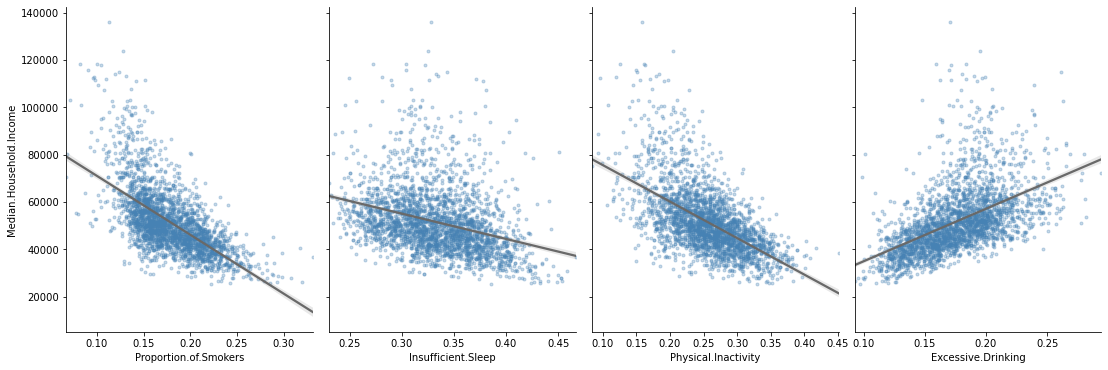

In [33]:
sns.pairplot(data=county_data, y_vars=['Median.Household.Income'], x_vars=c, 
             kind='reg', plot_kws={'line_kws':{'color':'dimgrey'}, 'scatter_kws': 
             {'alpha': 0.3,'color':'steelblue'}},markers='.',height=5,aspect=0.75);

<h3><center>Median Household Income by State</center></h3>

* Median household income is lower, on average, in southern states. Which might explain why they have worse health status as well.

In [34]:
plotly.offline.init_notebook_mode(connected=True)
i = county_data.groupby(['State.Abbreviation'])['Median.Household.Income'].mean().reset_index()
us = px.choropleth(i, locations = 'State.Abbreviation', color='Median.Household.Income', locationmode='USA-states', scope="usa")
us.update_layout(autosize=False, width=700, height=300, margin={"r":0,"t":0,"l":0,"b":0})

<h3><center>Age vs. Income</center></h3>

* Interestingly, the following regression plot shows a slight negative correlation between the percentage of the population over 65  years old and the median household income in a county

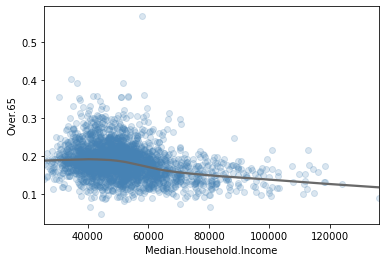

In [35]:
sns.regplot(x='Median.Household.Income', y='Over.65', data=county_data,
           lowess=True, scatter_kws={"alpha": 0.2, 'color': 'steelblue'}, 
           line_kws={"color": "dimgrey"});

<h3><center>Income vs. Health</center></h3>

* The following plot shows increased levels of poor health in counties with a median household income of less than 50k approximately. 
* The slope is significantly less steep for counties with a median household income of over 50k

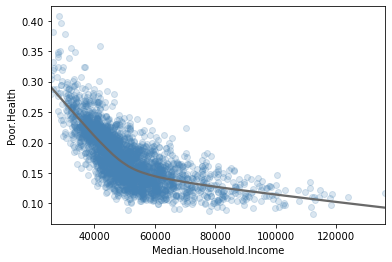

In [36]:
sns.regplot(county_data['Median.Household.Income'], county_data['Poor.Health'], lowess=True, 
            scatter_kws={"alpha": 0.2, 'color': 'steelblue'}, line_kws={"color": "dimgrey"});

<h3><center>Income Inequality vs. Health</center></h3>

* The following chart shows how the percentage of poor health is higher on average in counties with greater income inequality

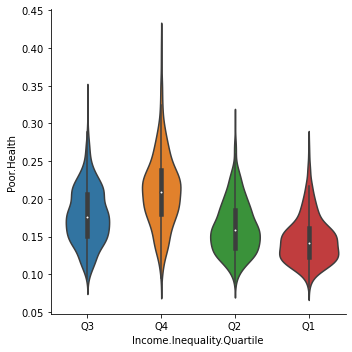

In [37]:
sns.catplot(x='Income.Inequality.Quartile', y='Poor.Health', kind='violin', data=county_data);

<h3><center>Income Inequality vs. Median Income</center></h3>

* Median household income is lower on average in counties with greater income inequality

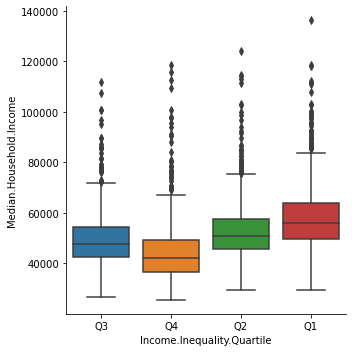

In [38]:
sns.catplot(x='Income.Inequality.Quartile', y='Median.Household.Income', kind='box', data=county_data);

<h3><center>Income Inequality vs. Behavioral Social Determinants</center></h3>

* Smoking, insufficient sleep, and inactivity are more common on average in counties with greater income inequality, while excessive drinking is slightly more common in counties with less disparity.

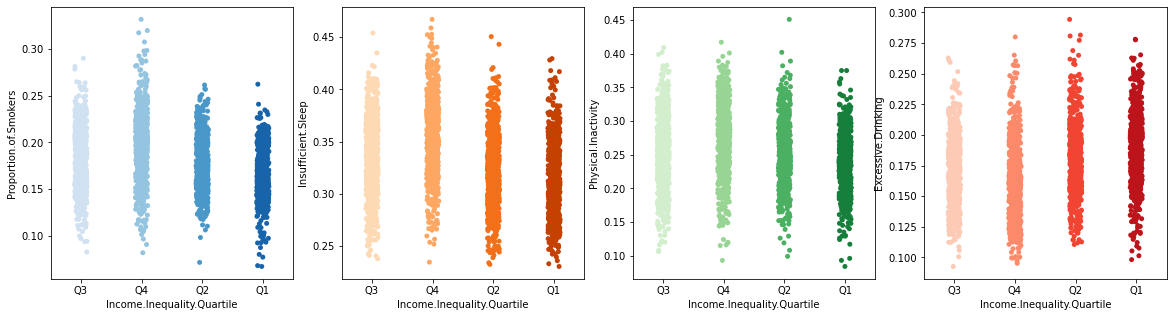

In [39]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5))
sns.stripplot(x='Income.Inequality.Quartile', y='Proportion.of.Smokers', data=county_data, ax=axs[0], palette='Blues');
sns.stripplot(x='Income.Inequality.Quartile', y='Insufficient.Sleep', data=county_data, ax=axs[1],  palette='Oranges');
sns.stripplot(x='Income.Inequality.Quartile', y='Physical.Inactivity', data=county_data, ax=axs[2], palette='Greens');
sns.stripplot(x='Income.Inequality.Quartile', y='Excessive.Drinking', data=county_data, ax=axs[3],  palette='Reds');

<h3><center>Smoking vs. Drinking</center></h3>

* The relationship between smoking is interesting since, in general, it shows that the greater the percentage of smokers in a county, the lower that of excessive drinkers. 
* While initially counterintuitive, our previous analysis shows a positive correlation between income and drinking, which might explain this relationship –on average, the greater a county's income, the higher the drinking percentage and the lower the smoking percentage.

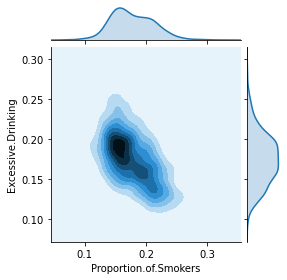

In [40]:
sns.jointplot('Proportion.of.Smokers', 'Excessive.Drinking', data=county_data, kind='kde', height=4);

<h3><center>Exploratory Analysis Takeaways</center></h3>

* Median household income has is strongly negatively correlated with poor health, which makes it a good predictor. 
* Bad habits are good correlated with poor health, except for drinking. This might be explained because drinking is more common in wealthier counties, where the health status is better on average. 
* We see higher percentages of poor health in counties with greater income inequality. The relationship between bad habits and income inequality is very similar to that of income. 
* The percentage of people over 65 years old is, surprisingly, not correlated with poor health.
* Fitting a decision tree regression model will help us identify the most important predictor variables for determining poor health, which so far seem to be median income and behavioral social determinants, in that order. 


<h2><center>3. FITTING THE DECISION TREE</center></h2>
<h3><center>Preparing the Data</center></h3>

* Before fitting the model, we first need to clean up the data by removing ID variables and isolating the $X$ and $Y$ variables.
* To prepare $X$, we first binarize the categorical variables, and ultimately merge continuous and categorical variables back together. 
* Lastly, we divide $X$ and $Y$ into testing and training sets using a 80/20 Train-Test split
* The tree does not include the "Over.65" variable for simplicity

In [41]:
# Preparing the data
X_cts = county_data.iloc[:,5:11]
X_cts.drop(['Income.Inequality.Quartile'], axis=1, inplace=True)

X_cat_bin = pd.get_dummies(county_data['Income.Inequality.Quartile'], drop_first=True)

X = pd.merge(X_cat_bin, X_cts, on='Row.Label')
y = county_data['Poor.Health']

# 80/20 Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1903)

<h3><center>Fitting and Finding the Best Tree</center></h3>

* One the data is prepared and split into training and testing sets, we can fit the decision tree regression model. 
* We run a cost-complexity prunning algorithm to find the optimal tree with the smallest $R^2$. This is the tree that will be plotted.

In [42]:
# Fitting the trees and doing cost-complexity prunning to find the best one
dtr = tree.DecisionTreeRegressor(random_state=1903)
path = dtr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
 
rgrs = []
for ccp_alpha in ccp_alphas: 
    dtr = tree.DecisionTreeRegressor(random_state=1903, ccp_alpha=ccp_alpha)
    dtr.fit(X_train, y_train)
    rgrs.append(dtr)

train_scores = [dtr.score(X_train, y_train) for dtr in rgrs]
test_scores = [dtr.score(X_test, y_test)for dtr in rgrs]
 
# Find the best tree
best = pd.Series(test_scores).idxmax()
best_tree = rgrs[best]

<h3><center>Plotting the Best Tree</center></h3>

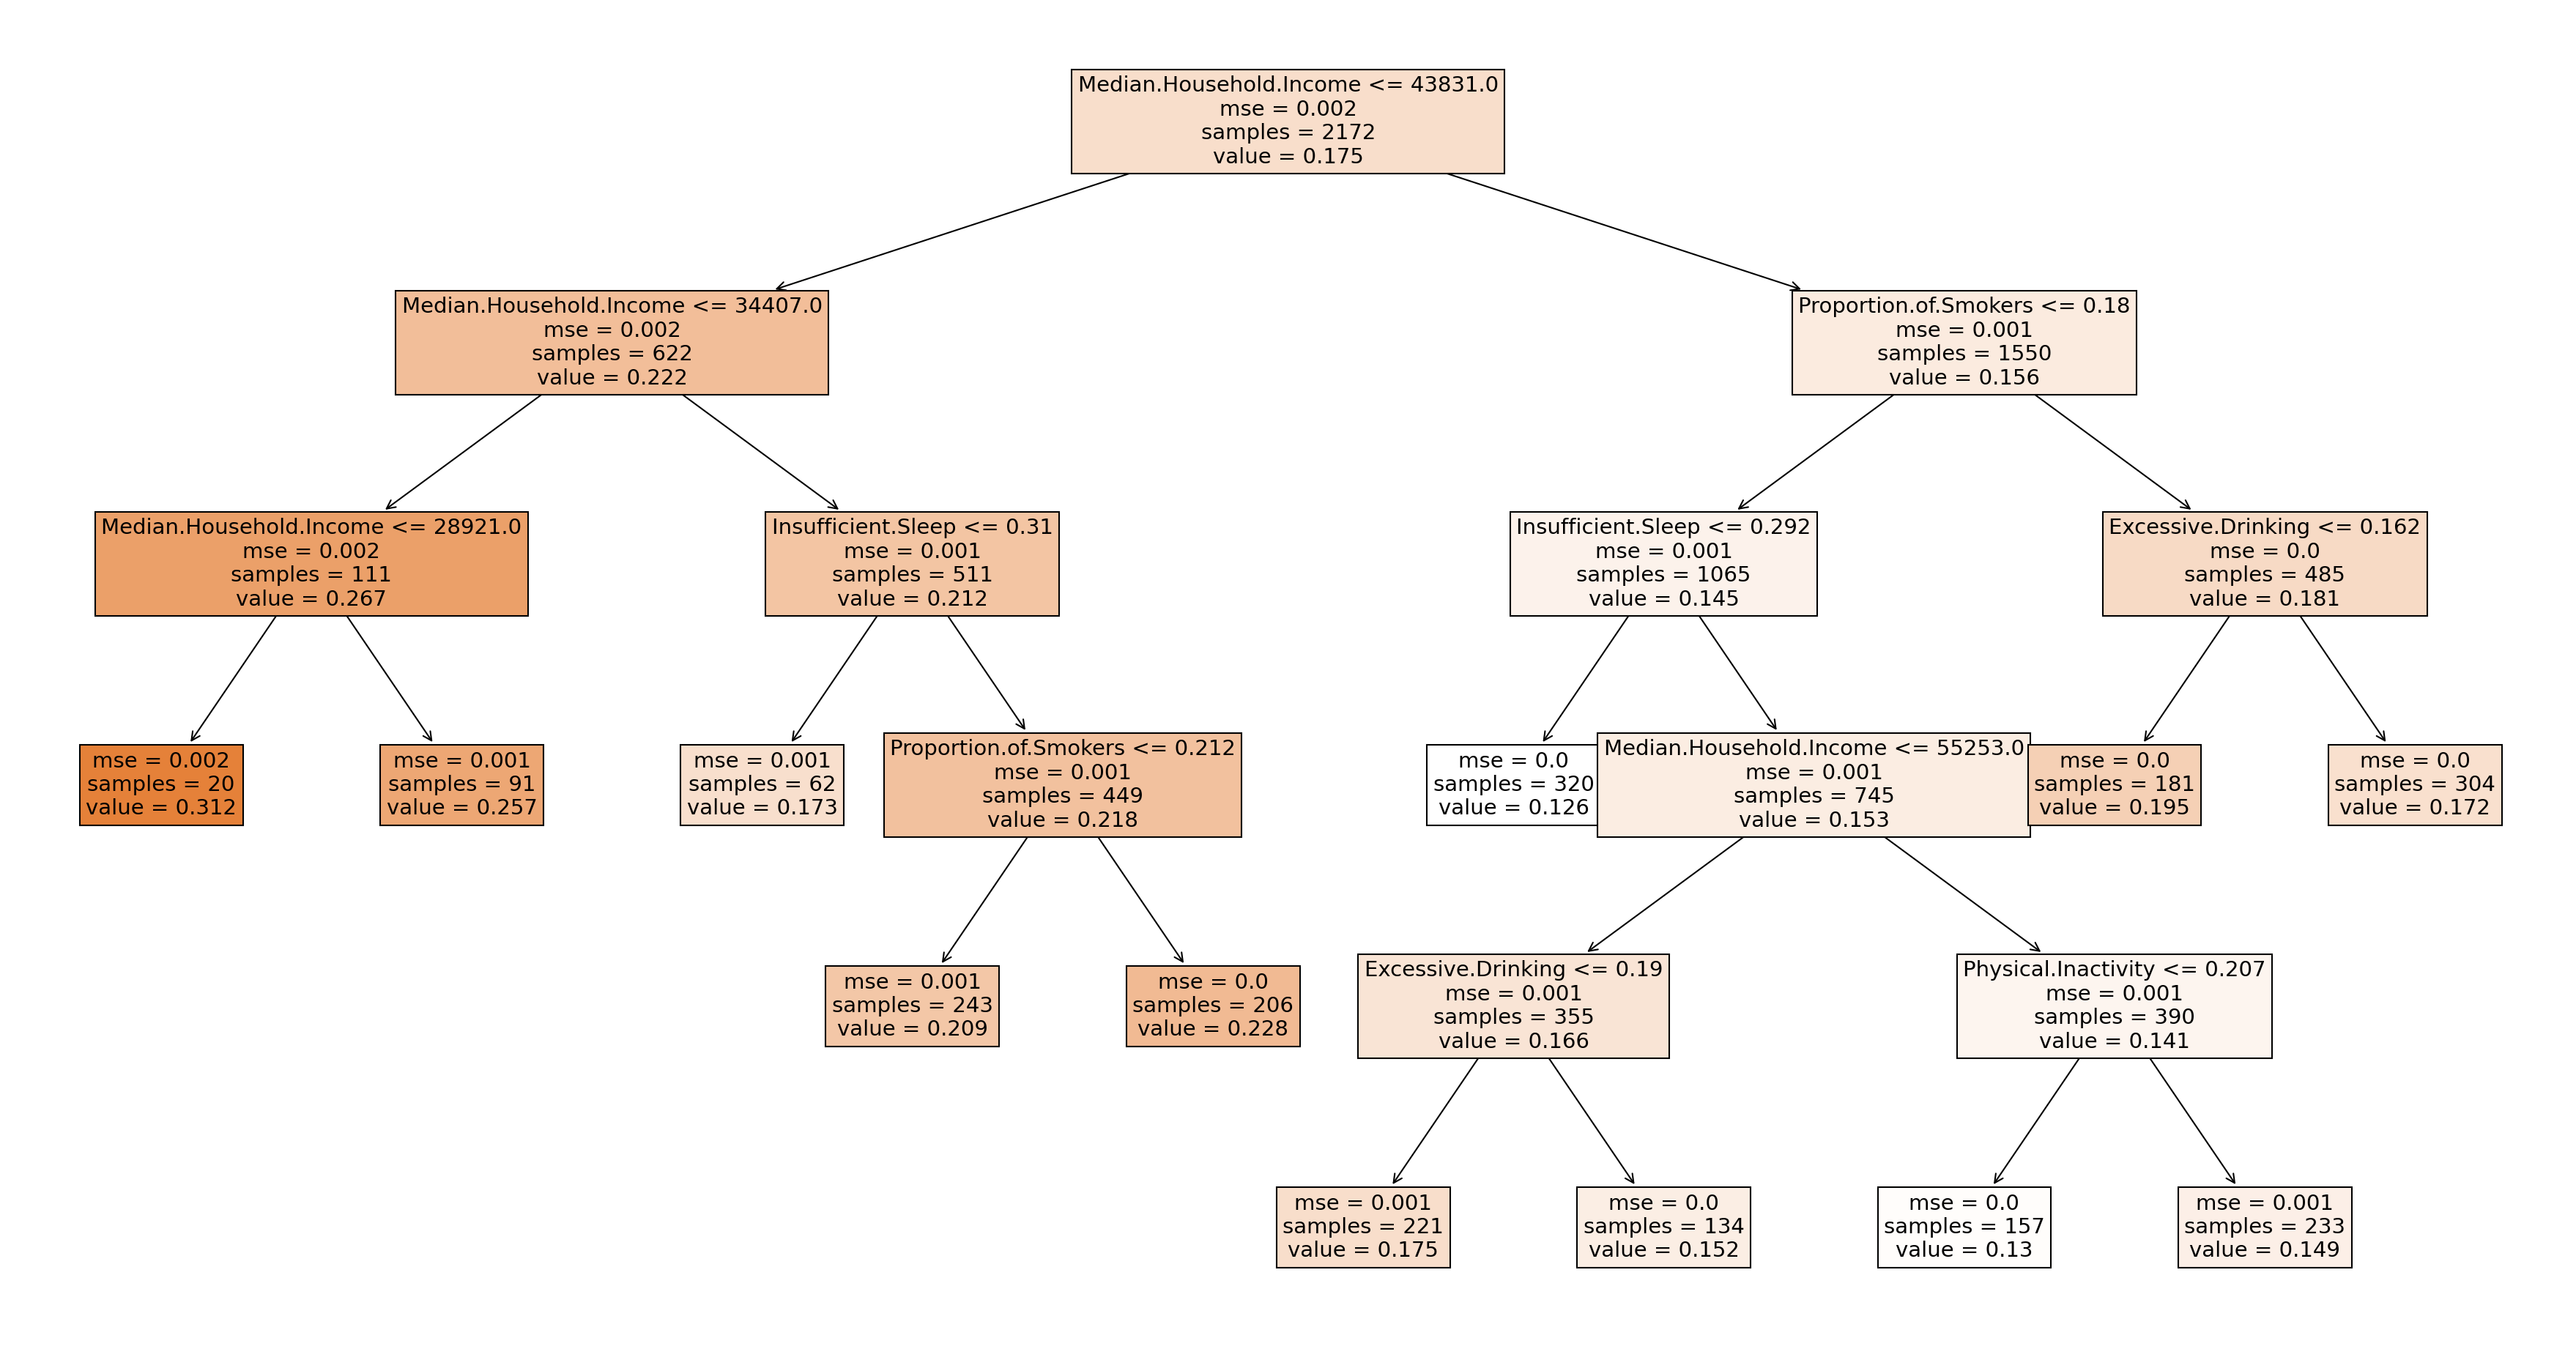

In [43]:
fig = plt.figure(num=None, figsize=(30,16), dpi=150, facecolor='w', edgecolor='k')
tree.plot_tree(best_tree, filled=True, feature_names=X_train.columns,fontsize=14);

<h3><center>Evaluating the Tree</center></h3>

* Predicting $Y$ values for our $X$-test set and comparing the outcomes relative to the $Y$-test set data gives us a good metric to evaluate the accuracy of our decision tree regression. 
* Computing the Mean Absolute Error, Mean Square Error, and RMSE of our predictions relative to the $Y$-test set gives us ~$1.8\%, 0.06\%$ and $2.4\%$, respectively (since Poor.Health values are expressed as a proportion between 0 and 1). This indicates that our tree's predictions are quite accurate.

In [44]:
# Predicting outcomes for our X_test set
y_pred = best_tree.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.01787006405505924
Mean Squared Error: 0.0005839641109698518
Root Mean Squared Error: 0.0241653493864635


<h3><center>Evaluating the Tree</center></h3>

* The following chart plots feature importances, which are a measure of how much each feature contributes to decreasing the weighted impurity of the regression tree.
* As we can see, median household income is by far the most important variable in our model, followed by proportion of smokers, and insufficient sleep, which is followed, with smaller percentages, by excessive drinking and physical inactivity.  
* Going back to our tree, these results make sense, since the node with the highest poor health percentage is reached only if median household income is less than 28,921 USD.

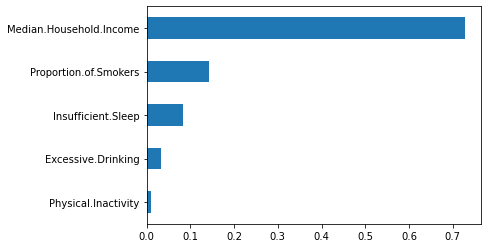

In [45]:
imp = pd.Series(best_tree.feature_importances_, index=X_train.columns).nlargest(5)
imp.plot(kind='barh').invert_yaxis();

<h2><center>4. CONCLUSIONS</center></h2>

* There is a possitive correlation between bad habits such as smoking, inactivity, and insufficient sleep and poor health. 
    * Excessive drinking is surprisingly the exception, as it is negatively correlated with poor health. However, this is likely explained by this variable's relationship with income and income's importance in predicting health status. 

* Counties with a higher median household income and lower income inequality, on average, have a better health status

* There is a relationship between behavioral and environmental social determinants: higher percentages of smokers and inactivity are more common in poorer counties, while a higher percentage of excessive drinking is more common in wealthier ones. Insufficient sleep is slightly more common in lower income counties.



* Age's impact on health status is not as important as one might initially think. The percentage of people over 65 in a county is not correlated with poor health.

* Median household income is by far the most important predictor of health, followed by proportion of smokers and insufficient sleep, and to a lesser extent, excessive drinking and physical inactivity.  
    * Based on our model, the worst health status can be expected in counties with a median household income of less than 28,921 USD.
    * The best health status can be expected in counties with a median household income greater than 28,921 USD, with less than 18% of smokers, and with less than 29.2% of insufficient sleep among its poupulation. 